In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
ndf = pd.read_csv('datasets/salesperdayIowaLiqour.csv',index_col=[0],parse_dates=['date'])

In [4]:
ndf[:20]

,date,sales
0,2012-01-03,1012493.81
1,2012-01-04,860053.73
2,2012-01-05,940194.93
3,2012-01-06,0.00
4,2012-01-07,0.00
5,2012-01-08,0.00
6,2012-01-09,933835.50
7,2012-01-10,900077.61
8,2012-01-11,773739.73
9,2012-01-12,927338.66


<Axes: >

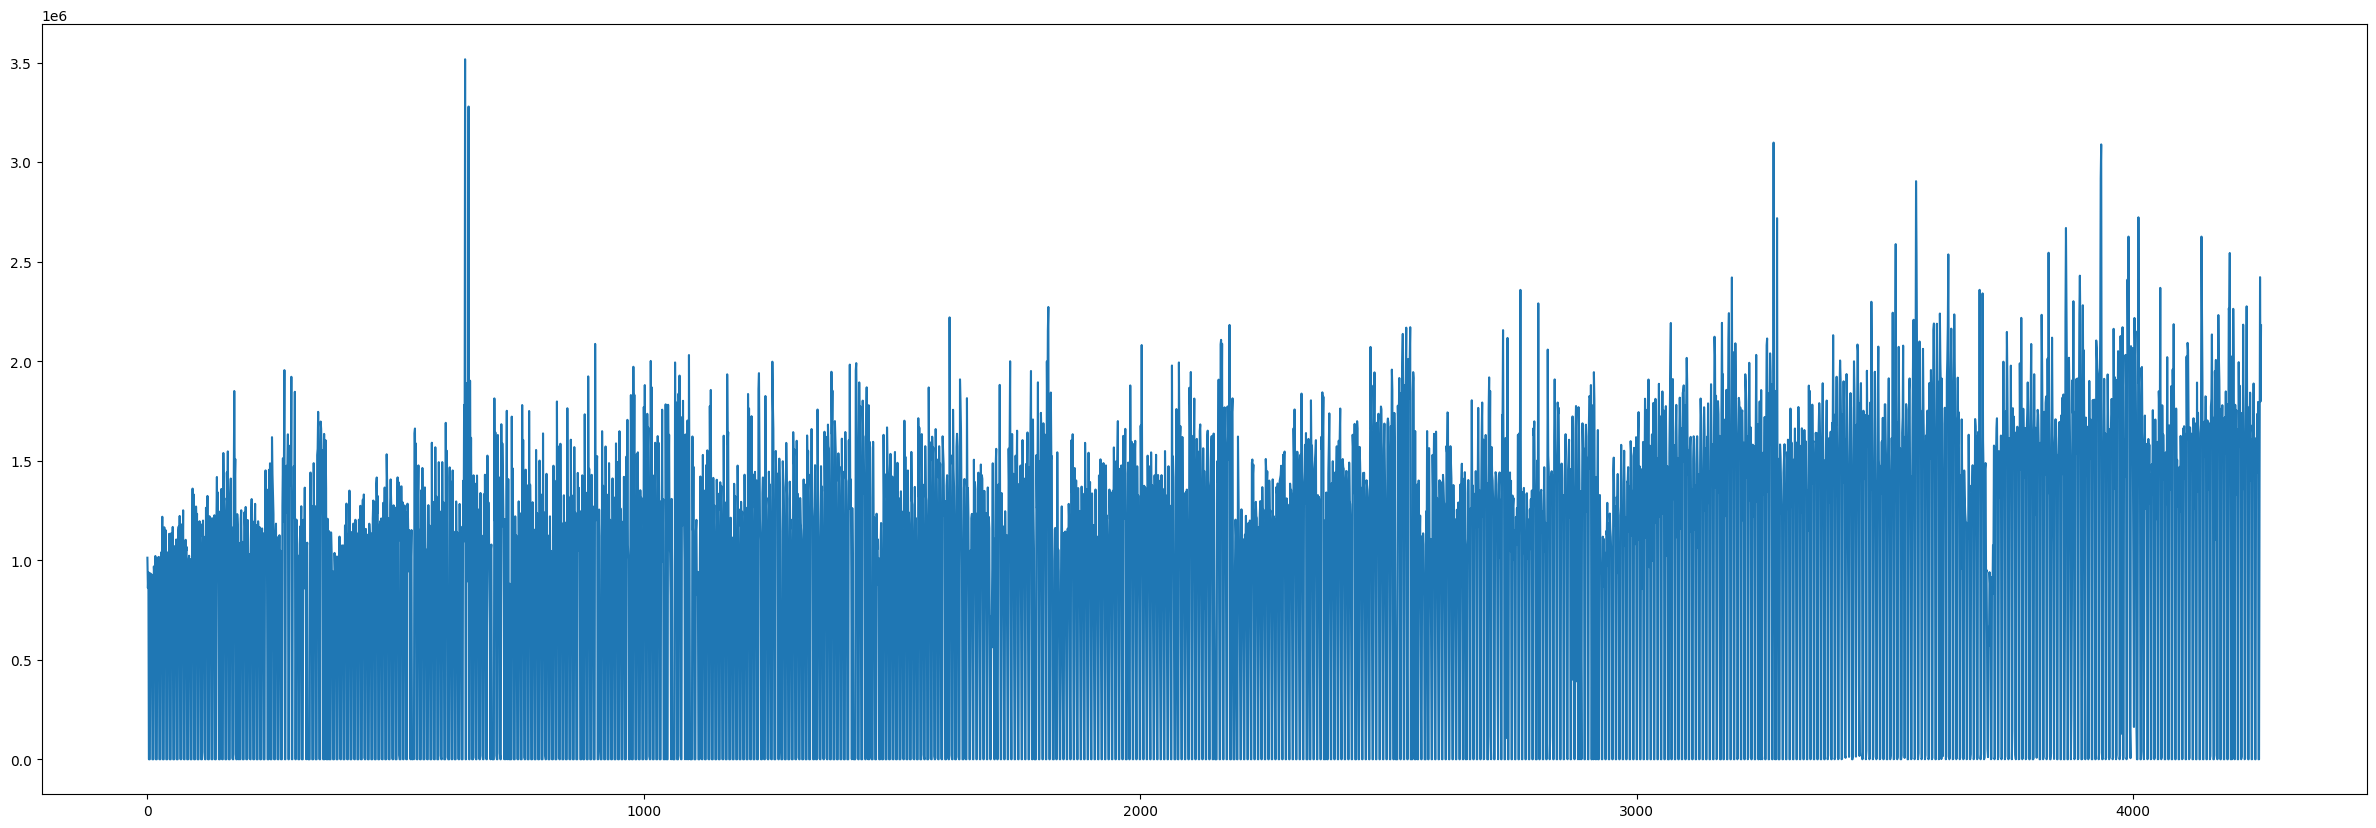

In [5]:
ndf['sales'].plot(figsize=(30,10))

In [6]:
# ndf.replace(0, np.nan,inplace=True)
ndf.dropna(inplace=True)
ndf.reset_index(inplace=True,drop=True)
ndf[:20]

,date,sales
0,2012-01-03,1012493.81
1,2012-01-04,860053.73
2,2012-01-05,940194.93
3,2012-01-06,0.00
4,2012-01-07,0.00
5,2012-01-08,0.00
6,2012-01-09,933835.50
7,2012-01-10,900077.61
8,2012-01-11,773739.73
9,2012-01-12,927338.66


In [7]:
ndf['Result'] = ndf['sales'].shift(-8)

<Axes: >

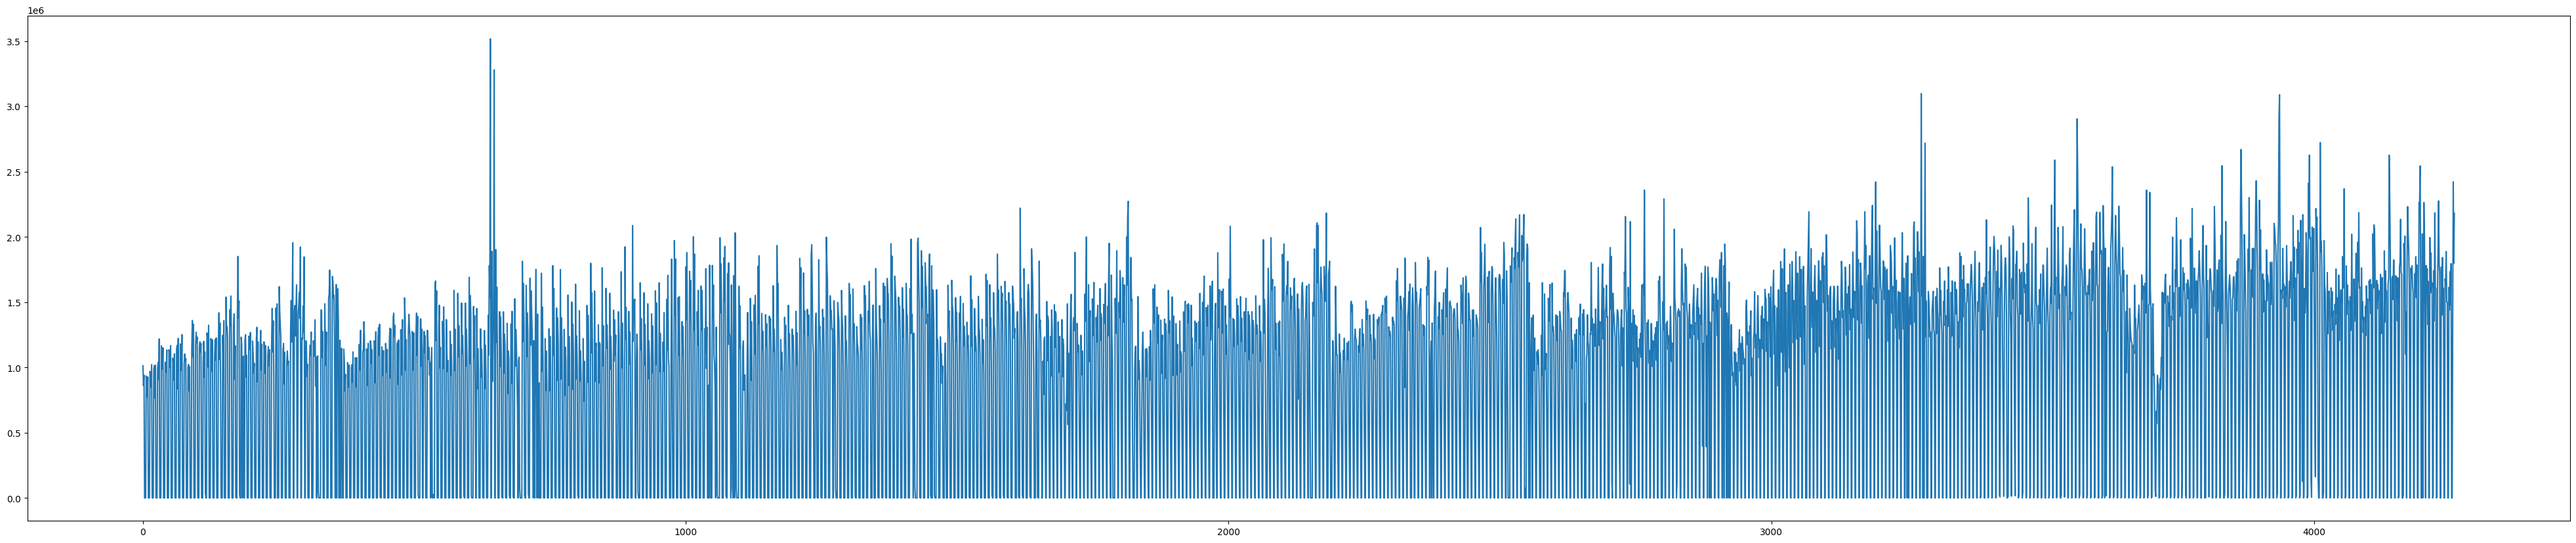

In [8]:
ndf['sales'].plot(figsize=(50,10))

In [9]:
import numpy as np

def normalizer(dataframe):
        return (dataframe - np.min(dataframe)) / (np.max(dataframe) - np.min(dataframe) )

In [10]:
ndf['sales'] = normalizer(ndf['sales'])
ndf['Result'] = normalizer(ndf['Result'])

In [11]:
ndf[-14:]
ndf.fillna(0,inplace=True)

In [12]:
import tensorflow as tf

2024-01-11 15:28:36.256431: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-11 15:28:36.298791: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 15:28:36.298828: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 15:28:36.298854: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-11 15:28:36.304688: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-11 15:28:36.305367: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [13]:
ndf.shape

(4259, 3)

In [14]:
gap = 7
dset = ndf['sales'].diff().shift(-1) 
avesales = dset.mean()
def test():
    df = pd.DataFrame(columns=[
        *[f'{i}' for i in range(gap)],
        'result', 
        'mean', 
        'ave',
        'goingup'
        ])
    # transposed_df = pd.DataFrame()
    for i in range(0, len(dset)-gap):
        chunk = dset.iloc[i:i+gap]  # Get a chunk of 7 rows
        if chunk.shape[0] == gap:
            # 
            df.loc[len(df)] = [
                *chunk.tolist(), 
                dset.iloc[i+gap],
                1 if dset.iloc[i+gap] >= avesales else -1, 
                chunk.mean(),
                1 if chunk.iloc[0] < chunk.iloc[6] else -1
                ]
    return df
test()

,0,1,2,3,4,5,6,result,mean,ave,goingup
0,-0.043352,0.022791,-0.267381,0.000000,0.000000,0.265572,-0.009600,-0.035929,-1.0,-0.004567,1.0
1,0.022791,-0.267381,0.000000,0.000000,0.265572,-0.009600,-0.035929,0.043682,1.0,-0.003507,-1.0
2,-0.267381,0.000000,0.000000,0.265572,-0.009600,-0.035929,0.043682,-0.263724,-1.0,-0.000522,1.0
3,0.000000,0.000000,0.265572,-0.009600,-0.035929,0.043682,-0.263724,0.000000,-1.0,0.000000,-1.0
4,0.000000,0.265572,-0.009600,-0.035929,0.043682,-0.263724,0.000000,0.000000,-1.0,0.000000,-1.0
...,...,...,...,...,...,...,...,...,...,...,...
4247,0.458689,-0.049460,0.083901,-0.072260,0.089591,-0.510462,0.000012,0.389467,1.0,0.000002,-1.0
4248,-0.049460,0.083901,-0.072260,0.089591,-0.510462,0.000012,0.389467,0.299251,1.0,-0.009887,1.0
4249,0.083901,-0.072260,0.089591,-0.510462,0.000012,0.389467,0.299251,-0.177544,-1.0,0.039929,1.0
4250,-0.072260,0.089591,-0.510462,0.000012,0.389467,0.299251,-0.177544,0.108668,1.0,0.002579,-1.0


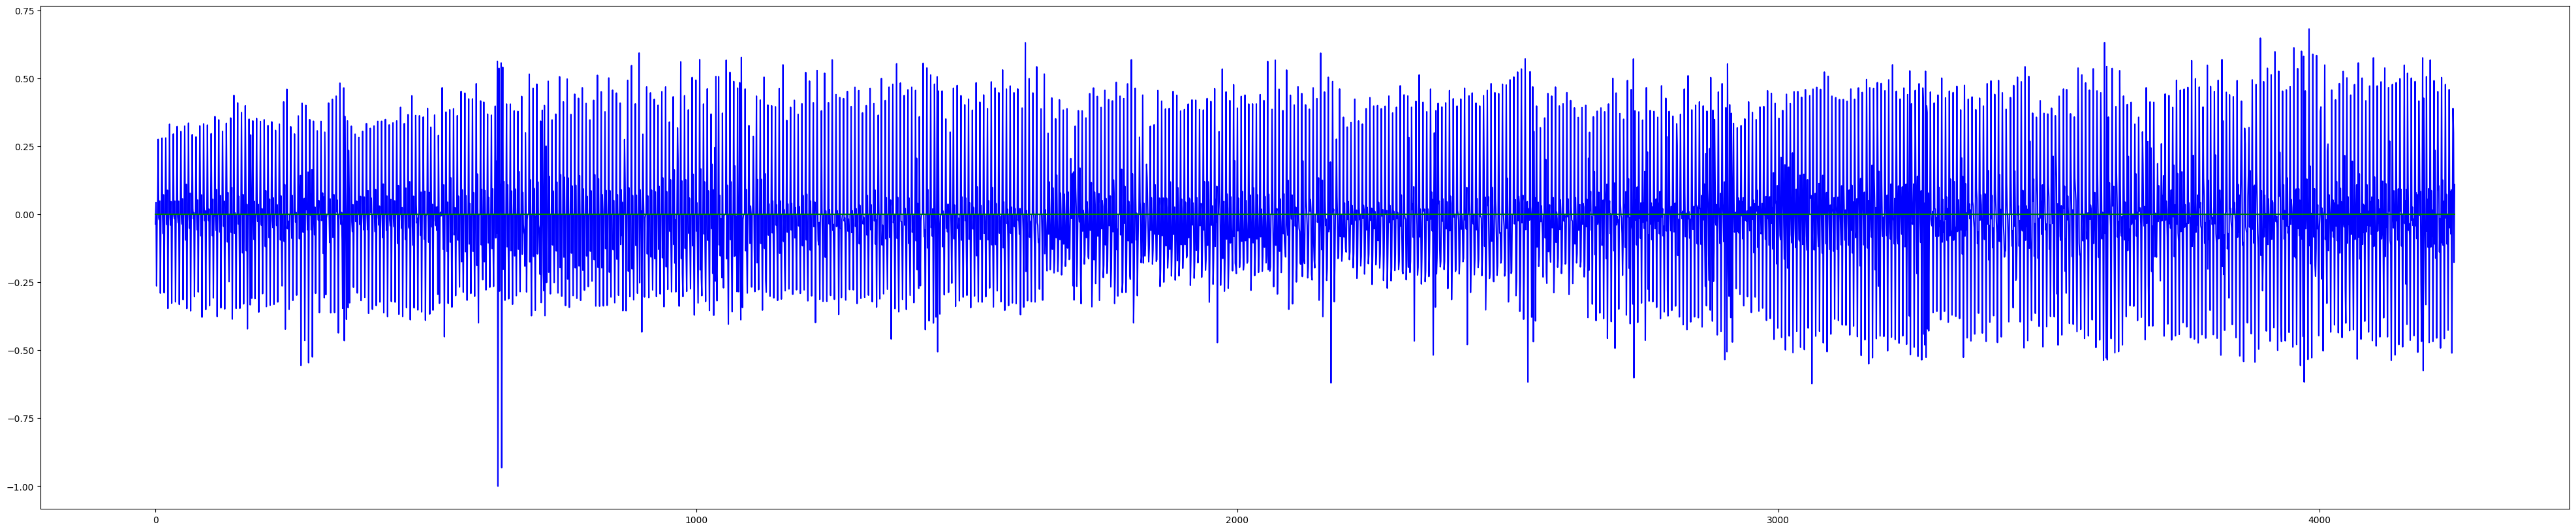

In [15]:
x = test().dropna()
y = x.pop('result')
y.plot(figsize=(50,10),color='blue')
plt.plot([avesales for i in range(len(x))],'-g')
# plt.plot(x['mean'],'ro')

In [16]:
y[:20]

0    -0.035929
1     0.043682
2    -0.263724
3     0.000000
4     0.000000
5     0.275472
6    -0.013520
7    -0.020111
8     0.048570
9    -0.290411
10    0.000000
11    0.000000
12    0.280242
13    0.007849
14   -0.070616
15    0.071622
16   -0.288870
17   -0.000226
18    0.000000
19    0.280605
Name: result, dtype: float64

In [17]:
x

,0,1,2,3,4,5,6,mean,ave,goingup
0,-0.043352,0.022791,-0.267381,0.000000,0.000000,0.265572,-0.009600,-1.0,-0.004567,1.0
1,0.022791,-0.267381,0.000000,0.000000,0.265572,-0.009600,-0.035929,1.0,-0.003507,-1.0
2,-0.267381,0.000000,0.000000,0.265572,-0.009600,-0.035929,0.043682,-1.0,-0.000522,1.0
3,0.000000,0.000000,0.265572,-0.009600,-0.035929,0.043682,-0.263724,-1.0,0.000000,-1.0
4,0.000000,0.265572,-0.009600,-0.035929,0.043682,-0.263724,0.000000,-1.0,0.000000,-1.0
...,...,...,...,...,...,...,...,...,...,...
4246,0.000000,0.458689,-0.049460,0.083901,-0.072260,0.089591,-0.510462,-1.0,0.000000,-1.0
4247,0.458689,-0.049460,0.083901,-0.072260,0.089591,-0.510462,0.000012,1.0,0.000002,-1.0
4248,-0.049460,0.083901,-0.072260,0.089591,-0.510462,0.000012,0.389467,1.0,-0.009887,1.0
4249,0.083901,-0.072260,0.089591,-0.510462,0.000012,0.389467,0.299251,-1.0,0.039929,1.0


In [18]:
f = x.to_numpy().reshape(x.shape[0],x.shape[1],1)
f[0]

array([[-0.04335219],
       [ 0.02279123],
       [-0.26738051],
       [ 0.        ],
       [ 0.        ],
       [ 0.26557197],
       [-0.00960035],
       [-1.        ],
       [-0.00456712],
       [ 1.        ]])

In [23]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(x.shape[1],1)),#,1
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dense(256,activation='selu'),
    tf.keras.layers.LeakyReLU(0.8),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256,activation='selu'),
    tf.keras.layers.ELU(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(256,dropout=0.1),
    tf.keras.layers.Dense(1)
    
    # tf.keras.layers.Input(shape=(x.shape[1])),#,1
    # # tf.keras.layers.LSTM(128,dropout=0.1),
    # # tf.keras.layers.Dense(256,activation='softplus'),
    # tf.keras.layers.Dense(256,activation='relu'),
    # tf.keras.layers.LeakyReLU(),
    # tf.keras.layers.Dense(1,)
])
model.summary()
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[
        tf.keras.metrics.MeanSquaredError(),
        'accuracy',
        tf.keras.metrics.R2Score(),
    ]
)



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 10, 256)           512       
                                                                 
 dense_5 (Dense)             (None, 10, 256)           65792     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 10, 256)           0         
                                                                 
 dropout_2 (Dropout)         (None, 10, 256)           0         
                                                                 
 dense_6 (Dense)             (None, 10, 256)           65792     
                                                                 
 elu_1 (ELU)                 (None, 10, 256)           0         
                                                                 
 dropout_3 (Dropout)         (None, 10, 256)          

In [24]:
# model.fit(f,y.to_numpy(),epochs=11, batch_size=32)
eval = 0
while eval <= 0.8:
    model.fit(f,y.to_numpy(),epochs=1,batch_size=16)
    eval = model.evaluate(x,y)[-1]

133/133 [==============================] - 1s 7ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - accuracy: 0.1515 - r2_score: 0.8274


In [25]:
n = 0
res = model.predict(x.to_numpy())
model.evaluate(x.to_numpy(),y)

133/133 [==============================] - 1s 8ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - accuracy: 0.1515 - r2_score: 0.8274


[0.009058088064193726,
 0.009058088064193726,
 0.15149377286434174,
 0.8273829221725464]

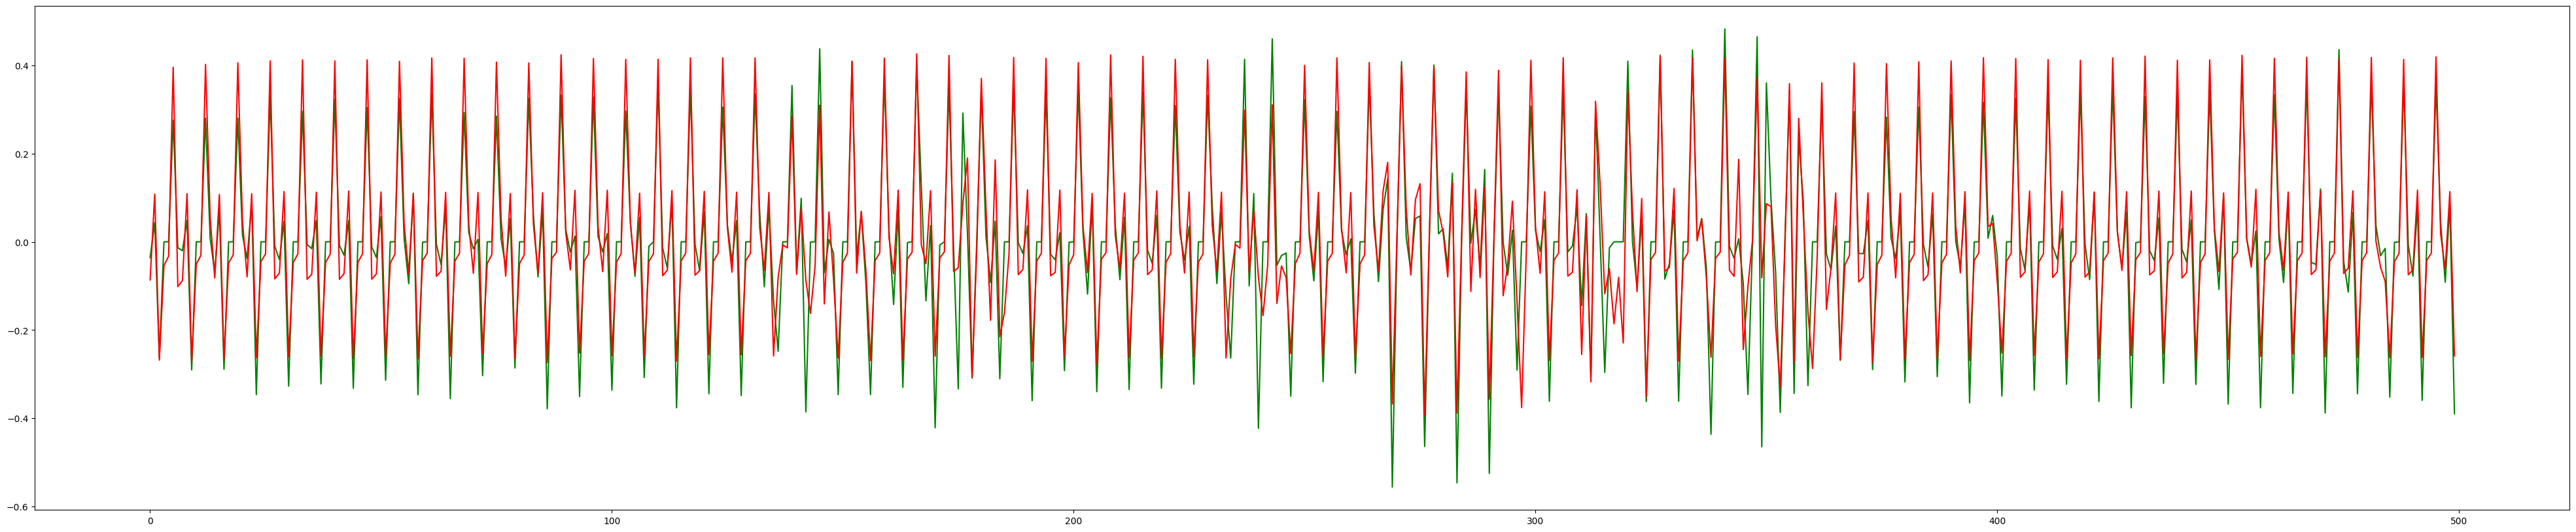

In [26]:

pred = [i[0] for i in res]

plt.figure(figsize=(50,10))
plt.plot(y[:500],'g-')
plt.plot(pred[:500],'-r')
# plt.plot(x['ave'],'yo')
# plt.plot(x['mean'],'ro')